In [1]:
import anndata as ad
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sys
import torch
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

/usr/local/lib/python3.6/dist-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
meta = pd.read_csv('../cite.rna.meta.csv')
out_x = pd.read_csv('../results/raw/bindsc_embed.adt.txt',header=None)
out_y = pd.read_csv('../results/raw/bindsc_embed.rna.txt',header=None)

np.all(meta.index.to_numpy() == out_y[0].to_numpy())

True

In [3]:
match_matrix = pairwise_distances(out_x.iloc[:,1:].to_numpy(), 
                                  out_y.iloc[:,1:].to_numpy(), metric="euclidean")
#match_matrix = np.exp(-match_matrix)

batch_code = meta['batch'].to_numpy()

match_matrix_1 = match_matrix[batch_code=='s1d2',:]
match_matrix_1 = match_matrix_1[:,batch_code=='s1d2']

match_matrix_2 = match_matrix[batch_code=='s3d7',:]
match_matrix_2 = match_matrix_2[:,batch_code=='s3d7']

In [4]:
neighbor_1 = np.argsort(match_matrix_1, axis=1, kind='stable')
neighbor_1 = np.argsort(neighbor_1, axis=1, kind='stable')

writer = open('../results/raw/neighborhood_s1d2_bindSC.txt','w')
writer.write('\n'.join(np.diag(neighbor_1).astype('str').tolist()))
writer.close()

In [5]:
neighbor_2 = np.argsort(match_matrix_2, axis=1, kind='stable')
neighbor_2 = np.argsort(neighbor_2, axis=1, kind='stable')

writer = open('../results/raw/neighborhood_s3d7_bindSC.txt','w')
writer.write('\n'.join(np.diag(neighbor_2).astype('str').tolist()))
writer.close()

In [4]:
merge = np.concatenate((out_y.iloc[:,1:].to_numpy(), 
                        out_x.iloc[:,1:].to_numpy()), axis=0)
merge = pd.DataFrame(merge)
merge.insert(0, 'index', np.concatenate((meta.index.to_numpy(), 
                                         meta.index.to_numpy()), axis=0))
merge.to_csv('../results/raw/bindSC_embed.txt', index=False)

### Silhoutte score

In [3]:
meta = pd.read_csv('../cite.rna.meta.csv')
out_x = pd.read_csv('../results/raw/bindsc_embed.adt.txt',header=None).iloc[:,1:].to_numpy()
out_y = pd.read_csv('../results/raw/bindsc_embed.rna.txt',header=None).iloc[:,1:].to_numpy()

#np.all(meta.index.to_numpy() == out_y[0].to_numpy())

In [4]:
from sklearn.metrics import silhouette_score
merge = np.concatenate((out_x, out_y), axis=0)

ct_int = meta['cell_type'].astype('category').cat.codes.to_numpy().astype('int')

ct_int = np.concatenate((ct_int,ct_int), axis=0)
tech_int = np.concatenate((np.zeros(meta.shape[0]),
                          np.ones(meta.shape[0])), axis=0)
batch_int = np.concatenate((meta['batch'].to_numpy(),
                            meta['batch'].to_numpy()), axis=0)

silhouette_ct = silhouette_score(merge, ct_int)
silhouette_tech = silhouette_score(merge, tech_int)
silhouette_batch = silhouette_score(merge, batch_int)


In [5]:
print(silhouette_ct)
print(1-silhouette_tech)
print(1-silhouette_batch)


0.0023040062566490136
0.996545237112762
0.9522727983005759


### Joint embedding

In [3]:
meta = pd.read_csv('../cite.rna.meta.csv')
out_x = pd.read_csv('../results/raw/bindsc_embed.adt.txt',header=None).iloc[:,1:].to_numpy()
out_y = pd.read_csv('../results/raw/bindsc_embed.rna.txt',header=None).iloc[:,1:].to_numpy()

#np.all(meta.index.to_numpy() == out_y[0].to_numpy())

In [4]:
ct_int = meta['cell_type'].astype('category').cat.codes.to_numpy().astype('int')
ct_name = meta['cell_type'].to_numpy()
ct_dic = {}
for i in range(len(np.unique(ct_int))):
    ct_dic[i] = ct_name[ct_int==i][0]
ct_int = np.concatenate((ct_int, ct_int), axis=0)

batch_int = meta['batch'].astype('category').cat.codes.to_numpy().astype('int')
batch_name = meta['batch'].to_numpy()
batch_dic = {}
for i in range(len(np.unique(batch_int))):
    batch_dic[i] = batch_name[batch_int==i][0]
batch_int = np.concatenate((batch_int, batch_int), axis=0)


In [5]:
merge = np.concatenate((out_x, out_y), axis=0)
ann_merge = ad.AnnData(
    X = merge
)
ann_merge.obs['cell_type'] = np.concatenate((ct_name, ct_name), axis=0)
ann_merge.obs['batch'] = np.concatenate((batch_name, batch_name), axis=0)
domains = np.zeros(len(merge))
domains = domains.astype('str')
domains[0:len(merge)//2] = 'ADT'
domains[len(merge)//2:] = 'GEX'
#domains = domains.astype('int')
ann_merge.obs['tech'] = domains
ann_merge.obs['tech'] = ann_merge.obs['tech'].astype("category")

In [6]:
import scanpy as sc
#sc.pp.neighbors(ann_merge, use_rep="X", metric="cosine")
#sc.tl.umap(ann_merge)
#sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)

sc.tl.pca(ann_merge, svd_solver='arpack')
sc.pp.neighbors(ann_merge, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(ann_merge)

... storing 'cell_type' as categorical
... storing 'batch' as categorical


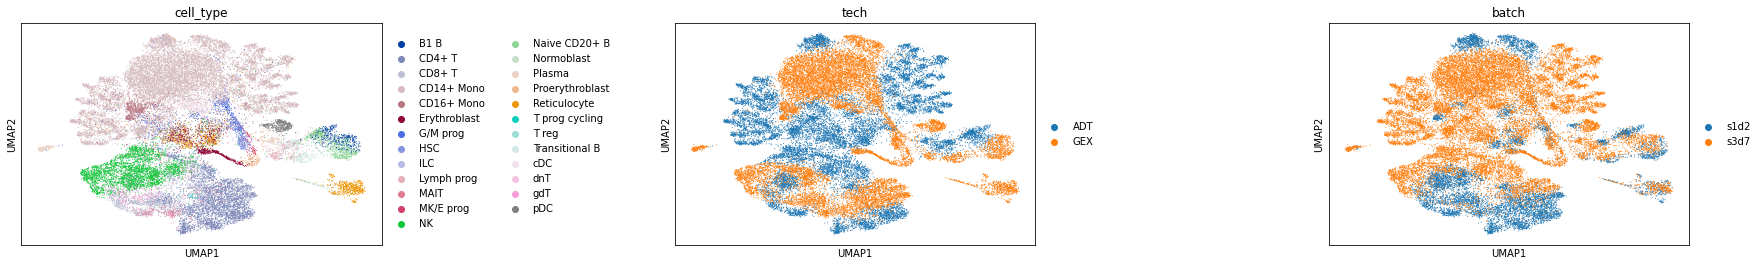

In [7]:
# X and consine
sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)


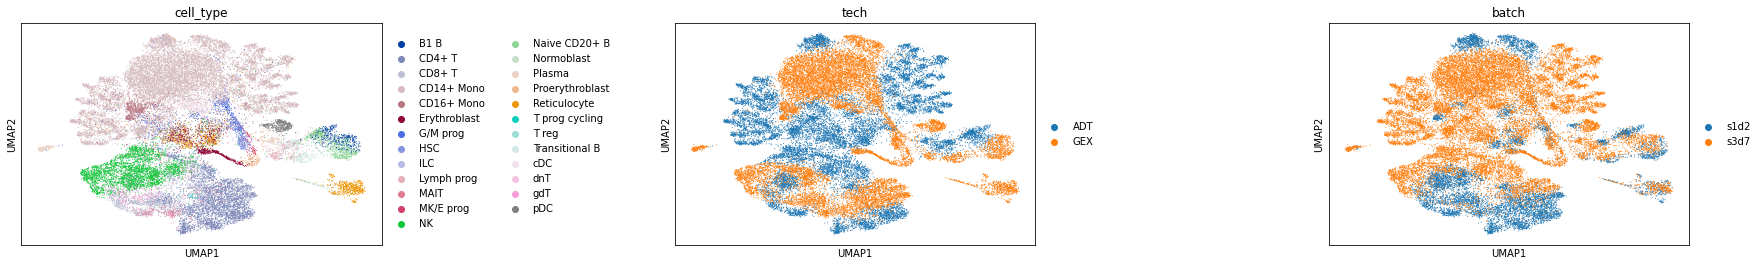

In [11]:
# PCA
sc.tl.pca(ann_merge, svd_solver='arpack')
sc.pp.neighbors(ann_merge, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(ann_merge)
sc.pl.umap(ann_merge, color=["cell_type", "tech", "batch"], wspace=0.65)


In [8]:
combined_embed = pd.DataFrame(ann_merge.obsm['X_umap'])
combined_embed.insert(0, 'index', ann_merge.obs_names.to_numpy())
combined_embed.columns = ['index','UMAP_1','UMAP_2']
combined_embed.to_csv('../results/raw/bindSC_UMAP.txt', index=False)

### Label transfer accuracy

In [7]:
meta = pd.read_csv('../cite.rna.meta.csv')
out_x = pd.read_csv('../results/raw/bindsc_embed.adt.txt',header=None).iloc[:,1:].to_numpy()
out_y = pd.read_csv('../results/raw/bindsc_embed.rna.txt',header=None).iloc[:,1:].to_numpy()

#np.all(meta.index.to_numpy() == out_y[0].to_numpy())

In [8]:
input_mod1 = ad.read_h5ad('../data/Cite_GEXtest.h5ad')


In [9]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

def KNN_acc(representations, labels, nn=5):
    indeces = np.arange(representations.shape[0])
    #representations = StandardScaler().fit_transform(representations)
    #pca = PCA(n_components=10)
    #pca.fit(representations[indeces])
    #X_reduced = pca.transform(representations[indeces])
    X_reduced = representations
    neigh = KNeighborsClassifier(n_neighbors=nn, weights='distance')
    n = int(len(representations) // 2)
    neigh.fit(X_reduced[0:n,:], labels)
    ylabel = neigh.predict(X_reduced[n:,:])
    check = len(ylabel) == n
    #print(check)
    acc = np.mean(labels == ylabel)
    print("Accuracy is %s"%(acc))
    return ylabel

In [10]:
merge = np.concatenate((out_x, out_y), axis=0)
labels = meta['cell_type'].astype('category').cat.codes.to_numpy()

In [11]:
#200
#Accuracy is 0.6485242127764532
#for i in range(5,105,5):
#    print(i)
#    pred_y = KNN_acc(merge, labels, nn=i)
#    print()
pred_y = KNN_acc(merge, labels, nn=25)

Accuracy is 0.7726291649804398


In [12]:
input_mod1.obs['cell_type_name'] = input_mod1.obs['cell_type']
input_mod1.obs['cell_type'] = input_mod1.obs['cell_type'].cat.codes
cell_type_code = input_mod1.obs[['cell_type','cell_type_name']]
cell_type_code = pd.DataFrame({'code':cell_type_code['cell_type'].unique(),
                              'name':cell_type_code['cell_type_name'].unique()})
cell_type_code = cell_type_code.sort_values('code')
cell_type_code.index = cell_type_code['code']

pred_y = cell_type_code.loc[pred_y,'name'].to_numpy()
labels_x = input_mod1.obs['cell_type_name'].to_numpy()


In [13]:
pred_df = pd.DataFrame({'cell_type':labels_x,'prediction':pred_y})
pred_df.to_csv('../results/raw/bindSC_prediction.txt')

In [14]:
ct_df = pd.DataFrame({'cell_type':labels_x,
                     'prediction':pred_y})

ct_heatmap = pd.DataFrame(np.zeros((25,25)))
ct_heatmap.index = input_mod1.obs['cell_type_name'].unique().tolist()
ct_heatmap.columns = input_mod1.obs['cell_type_name'].unique().tolist()
for i in range(25):
    for j in range(25):
        tmp = ct_df.loc[(ct_df['cell_type'] == ct_heatmap.index[i]),:]
        ct_heatmap.iloc[i,j] = np.mean(tmp['prediction'] == ct_heatmap.columns[j])
        

<AxesSubplot:>

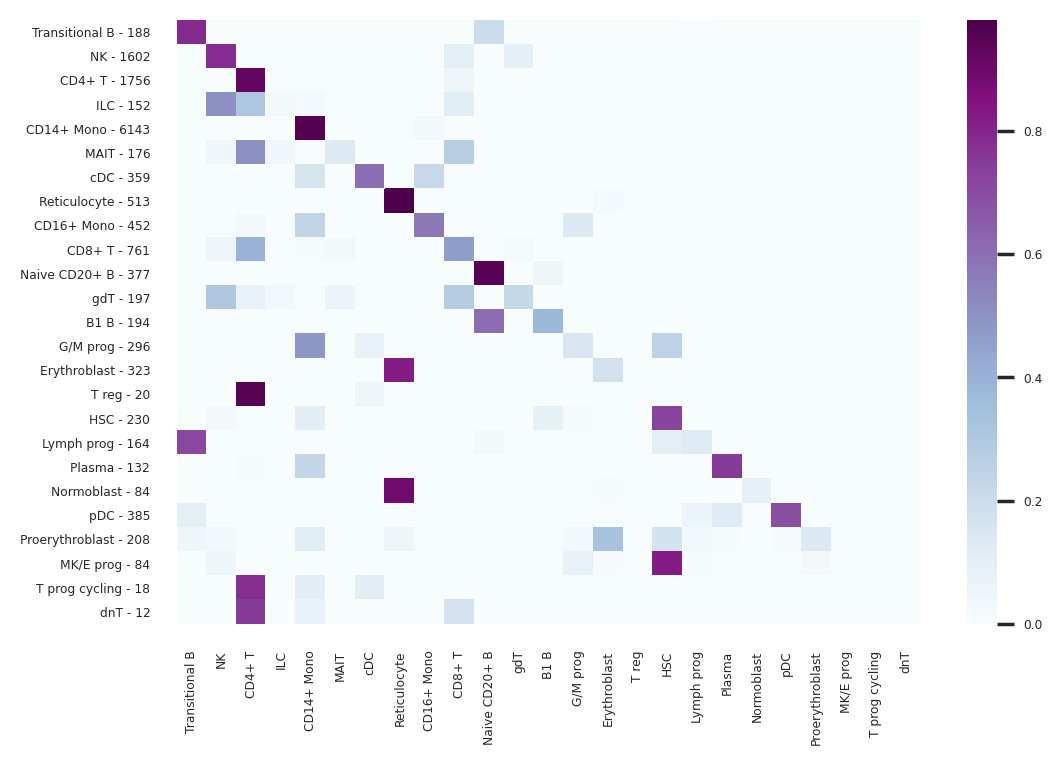

In [15]:
ct_heatmap.index = ct_heatmap.index + ' - ' + ct_df['cell_type'].value_counts().astype(str)[ct_heatmap.index]
sns.set(rc={"figure.dpi":200, 'savefig.dpi':100},font_scale=0.4)
mask = ct_heatmap.isnull()
sns.heatmap(ct_heatmap, mask=mask, cmap="BuPu")

In [16]:
acc_df = pd.DataFrame({'cell_type':ct_heatmap.columns.tolist(),
                       'bindSC': np.diag(ct_heatmap)})
acc_df.to_csv('../results/raw/bindSC_transfer_acc.csv')